In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


#### Reading the input files

In [ ]:
df_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
df_test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')

#### Exploratory data analysis

In [ ]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_train.head() #top 5 rows of training data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df_train.shape #number of rows and cols in df_train dataframe

(159571, 8)

In [ ]:
target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate'] #target values

In [ ]:
df_train.drop(['id'],axis=1,inplace=True) #drop Id column

In [ ]:
df_train.head() #top 5 rows after dropping Id

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df_train.isna().sum() #check for null values

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
df_train_labels = df_train.drop(['comment_text'],axis=1)
df_train_labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [ ]:
cnt_lables = df_train_labels.sum()
cnt_lables_df = pd.DataFrame(cnt_lables)

In [ ]:
cnt_lables_df.rename(columns={0:'Counts'},inplace= True)

In [ ]:
cnt_lables_df.sort_values('Counts',ascending=False) #total count for each label in the training data

,Counts
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


In [ ]:
df_test_labels #test labels from the CSV file

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [ ]:
df_train["comment_text"].isna().any() #null check

False

In [ ]:
df_test["comment_text"].isna().any() #null check

False

#### Cleaning the data

In [ ]:
def clean_comments(comments):
    comments = comments.lower()
    comments = re.sub(r"what's", "what is ", comments)
    comments = re.sub(r"\'ll", " will ", comments)
    comments = re.sub(r"\'s", " ", comments)
    comments = re.sub('\W', ' ', comments)
    comments = re.sub(r"\'ve", " have ", comments)
    comments = re.sub(r"can't", "cannot ", comments)
    comments = re.sub(r"n't", " not ", comments)
    comments = re.sub(r"\'re", " are ", comments)
    comments = re.sub(r"\'d", " would ", comments)
    comments = re.sub(r"i'm", "i am ", comments)
    comments = re.sub(r"\'scuse", " excuse ", comments)
    comments = re.sub('\s+', ' ', comments)
    comments = comments.strip(' ')
    return comments

In [ ]:
df_train['comment_text'] = df_train['comment_text'].map(lambda com : clean_comments(com))
df_test['comment_text'] = df_test['comment_text'].map(lambda com : clean_comments(com))

In [ ]:
X = df_train.comment_text
test_X = df_test.comment_text

#### The magnitude of each word in a word cloud, a visual representation of text data, represents its frequency or significance in the dataset.

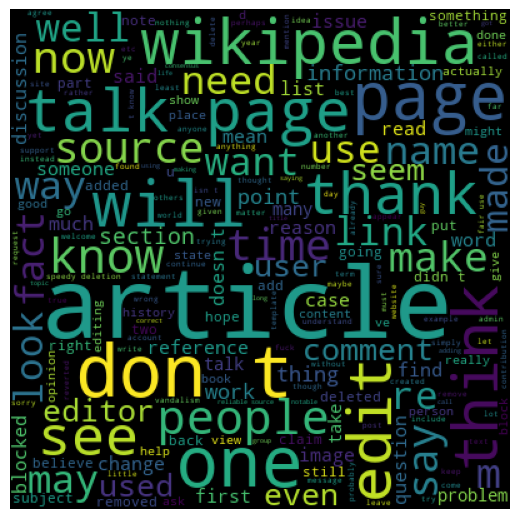

In [ ]:
wordCloud = WordCloud(stopwords=set(STOPWORDS),width = 400, height=400,min_font_size=4).generate(" ".join(X.values))
plt.figure(figsize = (11, 5), facecolor = None)
plt.imshow(wordCloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#### Correlation between target labels

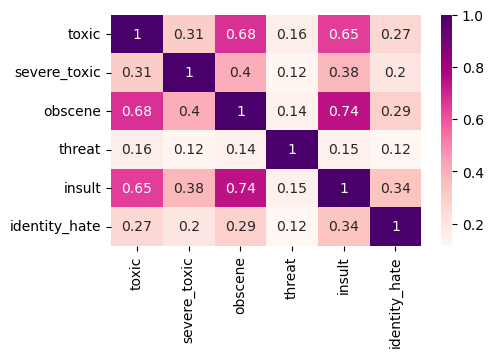

In [ ]:
labels_cor = df_train[target].corr()
plt.figure(figsize=(5,3))
sns.heatmap(labels_cor, annot=True, cmap='RdPu');

#### TF-IDF Vectorizer
What: Converts each document into a set of words and their counts and relative importance.

Why: To use a machine learning model, we must convert unstructured text into numeric features.

In [ ]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')
X_train_dtm = vect.fit_transform(X)
X_test_dtm = vect.transform(test_X)

#### Trying to classify the comments by predicting which target label they belong to using regression but here it assumes no correlation

In [ ]:
Result_binary = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')

logreg = LogisticRegression(max_iter=1000)
for com in target:
    y_train = df_train[com]
    logreg.fit(X_train_dtm, y_train)
    y_predict_class = logreg.predict(X_train_dtm)
    print('Training accuracy for {}: {}'.format(com,accuracy_score(y_train, y_predict_class)))
    y_test_prob = logreg.predict_proba(X_test_dtm)[:,1]
    Result_binary[com] = y_test_prob


Training accuracy for toxic: 0.9596731235625521
Training accuracy for severe_toxic: 0.9910134046913286
Training accuracy for obscene: 0.9798146279712479
Training accuracy for threat: 0.9972614071479153
Training accuracy for insult: 0.9727895419593786
Training accuracy for identity_hate: 0.9925801054076242


In [ ]:
Result_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998477,0.300359,0.998145,0.032802,0.952049,0.327444
1,0000247867823ef7,0.009628,0.002842,0.005075,0.001614,0.008088,0.003006
2,00013b17ad220c46,0.015509,0.001431,0.005927,0.000756,0.009881,0.002232
3,00017563c3f7919a,0.004140,0.002364,0.003889,0.001017,0.003969,0.000968
4,00017695ad8997eb,0.043471,0.001381,0.006008,0.001700,0.009445,0.001439


In [ ]:
Result_binary.to_csv('submission_binary.csv',index=False)

#### Test - Train Split (70% Train, 30% Test)

In [ ]:
train, test = train_test_split(df_train, test_size = 0.3, random_state = 1)
print("Train:", train.shape)
print("Test:", test.shape)

Train: (111699, 7)
Test: (47872, 7)


In [ ]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_comments(com))
test['comment_text'] = test['comment_text'].map(lambda com : clean_comments(com))

In [ ]:
X_train = train.comment_text
X_test = test.comment_text

In [ ]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')
X_train_dtm2 = vect.fit_transform(X_train)
X_test_dtm2 = vect.transform(X_test)

In [ ]:
X_train_dtm2.shape

(111699, 5000)

#### Using Randomforest Classifier

In [ ]:
classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=1000, max_leaf_nodes=None,
            min_impurity_decrease=0.0,min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,warm_start=False)

#### Getting input features as x_train and x_text and target values as y_train and y_test

In [ ]:
target = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
x_train = train.loc[:,'comment_text']
y_train = train[target]
x_test = test.loc[:,'comment_text']
y_test = test[target]

In [ ]:
classifier.fit(X_train_dtm2,y_train)

RandomForestClassifier(max_depth=100, max_features=1000, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=10, n_jobs=1)

In [ ]:
y_predict = classifier.predict(X_test_dtm2)
results = []
for i, label in enumerate(y_test.columns):
    accuracy = accuracy_score(y_test[label], y_predict[:, i])
    precision = precision_score(y_test[label], y_predict[:, i],average='weighted')
    recall = recall_score(y_test[label], y_predict[:, i],average='weighted')
    f1 = f1_score(y_test[label], y_predict[:, i],average='weighted')
    results.append([label, accuracy, precision, recall, f1])

columns = ['Label', 'Accuracy', 'Precision', 'Recall', 'F1-score']
df_results = pd.DataFrame(results, columns=columns)

display(df_results) # Results as Dataframe

,Label,Accuracy,Precision,Recall,F1-score
0,toxic,0.953438,0.950710,0.953438,0.950385
1,severe_toxic,0.989743,0.985939,0.989743,0.986650
2,obscene,0.978213,0.977402,0.978213,0.977695
3,threat,0.996762,0.993576,0.996762,0.995167
4,insult,0.967476,0.965359,0.967476,0.966172
5,identity_hate,0.991227,0.988702,0.991227,0.987967
